# <mark>READ DATASET & PRINT DATA TABLE</mark>

In [4]:
import pandas as pd
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

dataFrame = pd.read_csv('heart_2020_cleaned.csv', sep=',')
label = 'HeartDisease'
featureNames = dataFrame.columns

#dataFrame.head()
dataFrame.tail()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No
319794,No,46.56,No,No,No,0.0,0.0,No,Female,80 or older,Hispanic,No,Yes,Good,8.0,No,No,No


# DOWNSAMPLING 
for a balanced dataset, it has to be down/upcycled 

## Pie chart - Show the im/balance

No     292422
Yes     27373
Name: HeartDisease, dtype: int64


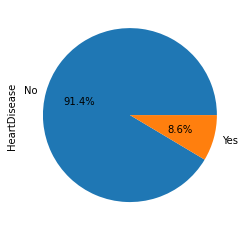

In [6]:
print(dataFrame[label].value_counts())
dataFrame.groupby(label).size().plot(kind='pie',
                                       y = label,
                                       label = "HeartDisease",
                                       autopct='%1.1f%%')

## <mark>Actual Downsampling</mark>

In [5]:
from sklearn.utils import resample

noHeartDiseases = dataFrame[dataFrame[label] == "No"]
withHeartDiseases  = dataFrame[dataFrame[label] == "Yes"]

noHeartDiseaseDownsample = resample(noHeartDiseases,
             replace=True,
             n_samples=len(withHeartDiseases),
             random_state=42) 
    
dataFrame = pd.concat([noHeartDiseaseDownsample, withHeartDiseases])

## Pie chart - Check the balance again

No     27373
Yes    27373
Name: HeartDisease, dtype: int64

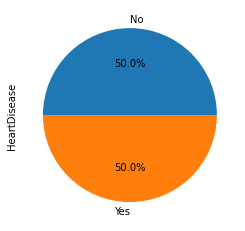

In [8]:
dataFrame.groupby(label).size().plot(kind='pie',
                                       y = label,
                                       label = "HeartDisease",
                                       autopct='%1.1f%%')
dataFrame[label].value_counts()

# DATA PREPARATION

## <mark>Transform Strings into Numbers</mark>

In [6]:
obj_list = dataFrame.select_dtypes(include='object').columns

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for obj in obj_list:
        dataFrame[obj] = le.fit_transform(dataFrame[obj].astype(str))
        
dataFrame.tail()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
319765,1,38.45,0,0,1,30.0,15.0,1,0,7,3,2,1,3,6.0,1,0,0
319767,1,36.21,1,0,0,0.0,0.0,1,0,11,3,2,1,2,8.0,0,0,0
319781,1,37.12,1,0,0,0.0,0.0,0,1,3,3,0,1,4,7.0,0,0,0
319786,1,33.20,1,0,0,0.0,0.0,0,0,8,3,2,1,4,8.0,1,0,0
319790,1,27.41,1,0,0,7.0,0.0,1,1,8,3,2,0,1,6.0,1,0,0


## <mark>Normalization</mark> 
Scaling data in a range from 0.0 to 1.0

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

dataFrameValues = dataFrame.values 
scaler = preprocessing.MinMaxScaler()
valueScaled = scaler.fit_transform(dataFrameValues)
dataFrame = pd.DataFrame(valueScaled, columns=dataFrame.columns)
dataFrame.tail()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
54741,1.0,0.329607,0.0,0.0,1.0,1.000000,0.5,1.0,0.0,0.583333,0.6,0.666667,1.0,0.75,0.217391,1.0,0.0,0.0
54742,1.0,0.301470,1.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.916667,0.6,0.666667,1.0,0.50,0.304348,0.0,0.0,0.0
54743,1.0,0.312900,1.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.250000,0.6,0.000000,1.0,1.00,0.260870,0.0,0.0,0.0
54744,1.0,0.263660,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.666667,0.6,0.666667,1.0,1.00,0.304348,1.0,0.0,0.0
54745,1.0,0.190931,1.0,0.0,0.0,0.233333,0.0,1.0,1.0,0.666667,0.6,0.666667,0.0,0.25,0.217391,1.0,0.0,0.0


The fit(data) method is used to compute the mean and std dev for a given feature to be used further for scaling.

The transform(data) method is used to perform scaling using mean and std dev calculated using the .fit() method.

The fit_transform() method does both fits and transform.

## Reducing Features

**be aware which features you wanna drop**

In [11]:
#dataFrame = dataFrame.drop(['AlcoholDrinking', 'PhysicalActivity', 'GenHealth', 'SleepTime', 'MentalHealth',  'Race'], axis=1)
#dataFrame.tail()

## Check the Data Quality again
### Empty Data Check

In [12]:
pd.options.mode.use_inf_as_na = True
dataFrame.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

## Zero Values

In [13]:
# Display how many 0 values each feature has
print((dataFrame == 0).sum())

HeartDisease        27373
BMI                     1
Smoking             27871
AlcoholDrinking     51643
Stroke              49581
PhysicalHealth      34261
MentalHealth        35689
DiffWalking         41483
Sex                 25911
AgeCategory          2128
Race                  963
Diabetic            41139
PhysicalActivity    15531
GenHealth            7726
SleepTime             114
Asthma              46215
KidneyDisease       50495
SkinCancer          47495
dtype: int64


## Correlation Matrix

In [14]:
featureLength = len(featureNames)
df_features_mean = dataFrame.iloc[:,0:featureLength]
df_features_mean.tail()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
54741,1.0,0.329607,0.0,0.0,1.0,1.000000,0.5,1.0,0.0,0.583333,0.6,0.666667,1.0,0.75,0.217391,1.0,0.0,0.0
54742,1.0,0.301470,1.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.916667,0.6,0.666667,1.0,0.50,0.304348,0.0,0.0,0.0
54743,1.0,0.312900,1.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.250000,0.6,0.000000,1.0,1.00,0.260870,0.0,0.0,0.0
54744,1.0,0.263660,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.666667,0.6,0.666667,1.0,1.00,0.304348,1.0,0.0,0.0
54745,1.0,0.190931,1.0,0.0,0.0,0.233333,0.0,1.0,1.0,0.666667,0.6,0.666667,0.0,0.25,0.217391,1.0,0.0,0.0


=> von Folie "Developing for AI (AIML) p.39" übernommen. => Ändert nichts am Output, also wozu?

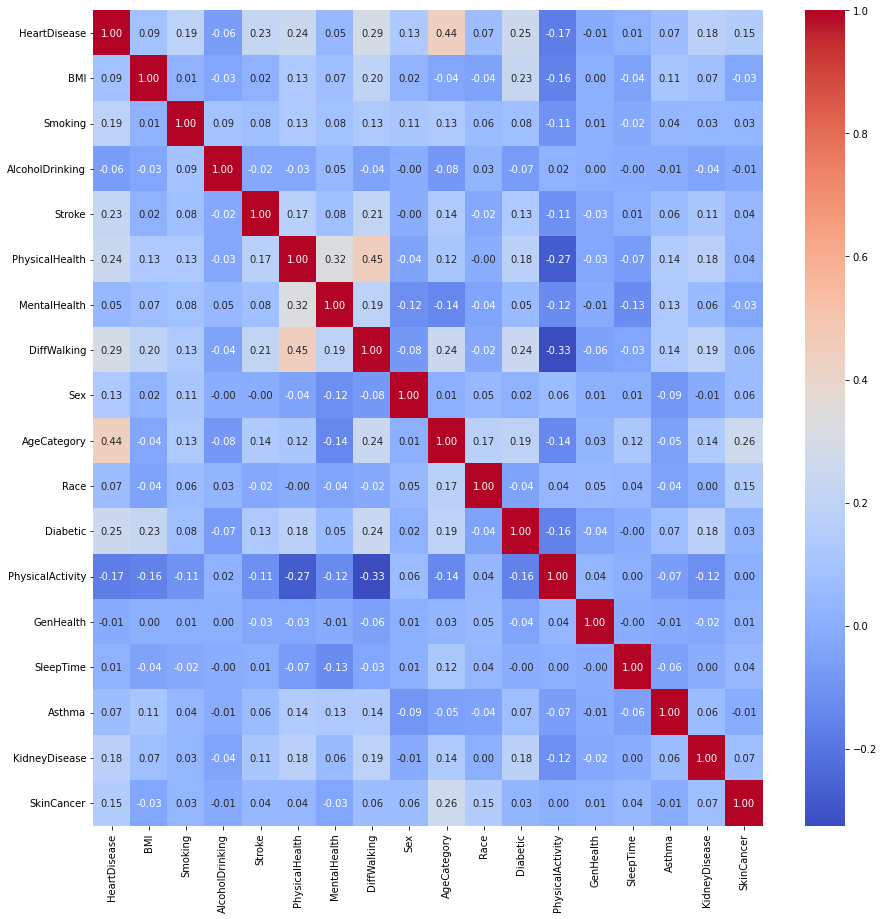

In [15]:
xd = dataFrame[featureNames]
yd = dataFrame[label]

sns.heatmap(
    data=df_features_mean.corr(),
    annot=True,
    fmt='.2f',
    cmap='coolwarm'
)

fig = plt.gcf()
fig.set_size_inches(15, 15)

plt.show()

# ALGORITHMS

## <mark>Splitting Into Test & Training Data</mark>

In [8]:
from sklearn.model_selection import train_test_split

X = dataFrame.drop(label, axis=1).values #Feature Values
y = dataFrame[label].values #heartDiseaseValues

np.random.seed(41)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train

array([[0.38738852, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.38638362, 1.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.18728803, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.14470544, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.38286647, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.23238287, 1.        , 0.        , ..., 1.        , 0.        ,
        0.        ]])

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(43796, 17)
(43796,)
(10950, 17)
(10950,)


## Algorithms with Overfitting Check

## KNN Overfitting Check failed

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

trainScores, testScores = list(), list()
neighbours = [i for i in range(1, 15)]

for i in neighbours:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    
    trainPrediction = knn.predict(X_train)
    trainAccuracy = accuracy_score(y_train, trainPrediction)
    trainScores.append(trainAccuracy)
    
    testPrediction = knn.predict(X_test)
    testAccuracy = accuracy_score(y_test, testPrediction)
    testScores.append(testAccuracy)
    print('>%d, train: %.3f, test: %.3f' % (i, trainAccuracy, testAccuracy))
    
pyplot.plot(neighbours, trainScores, '-o', label='Train')
pyplot.plot(neighbours, testScores, '-o', label='Test')
pyplot.legend()
pyplot.show()

KeyboardInterrupt: ignored

=> An Overfitting Analysis like this with KNN is inappropriate, according to 

https://machinelearningmastery.com/overfitting-machine-learning-models#attachment_11578

## KNN with Cross-Validation ~73%

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier()
scores = cross_val_score(knn, X_train, y_train, cv = 5) # cv = number of folds, default: 5
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2))

Accuracy: 72.98 (+/- 0.01)


### Confusion Matrix
More detailed Evaluation of the Accuracy

In [20]:
from sklearn import metrics
from sklearn.metrics import classification_report

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
testPrediction = knn.predict(X_test)

conf_matrix = metrics.confusion_matrix(y_test, testPrediction)

tn, fp, fn, tp = conf_matrix.ravel()
print(f"True negatives: {tn}, False positives: {fp}, False negatives: {fn}, True positives: {tp}")
print(classification_report(y_test, testPrediction))

True negatives: 3942, False positives: 1549, False negatives: 1397, True positives: 4062
              precision    recall  f1-score   support

         0.0       0.74      0.72      0.73      5491
         1.0       0.72      0.74      0.73      5459

    accuracy                           0.73     10950
   macro avg       0.73      0.73      0.73     10950
weighted avg       0.73      0.73      0.73     10950



Explanation of the report, copy pasted from the slides:

Precision: proportion of true positives among instances classified as positive, e.g.
the proportion of Iris virginica correctly identified as Iris virginica.

Recall: proportion of true positives among all positive instances in the data, e.g. the
number of sick among all diagnosed as sick.

F-1: weighted harmonic mean of precision and recall.


## Logistic Regression ~75%

>10, train: 75.000, test: 74.941
>20, train: 75.135, test: 75.388


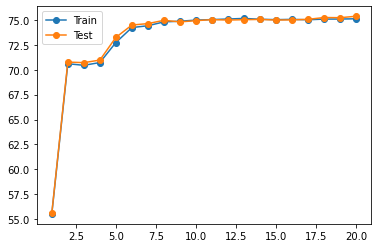

The point of NO overfitting is not existent? Stop iteration anyway at 20
Score:
75.38812785388129


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

trainScores, testScores = list(), list()
treeDepths = [i for i in range(1, 21)]

for i in treeDepths:
    model = LogisticRegression(max_iter=i)
    model.fit(X_train, y_train)
    
    trainPrediction = model.predict(X_train)
    trainAccuracy = accuracy_score(y_train, trainPrediction) * 100
    trainScores.append(trainAccuracy)
    
    testPrediction = model.predict(X_test)
    testAccuracy = accuracy_score(y_test, testPrediction) * 100
    testScores.append(testAccuracy)
    
    if i % 10 == 0: print('>%d, train: %.3f, test: %.3f' % (i, trainAccuracy, testAccuracy))

pyplot.plot(treeDepths, trainScores, '-o', label='Train')
pyplot.plot(treeDepths, testScores, '-o', label='Test')
pyplot.legend()
pyplot.show()

print("The point of NO overfitting is not existent? Stop iteration anyway at 20")
print("Score:")
print(model.score(X_test, y_test)*100)

## Random Forest Classifier ~76%

>1, train: 73.020, test: 73.324
>2, train: 73.587, test: 73.826
>3, train: 74.566, test: 75.032
>4, train: 75.452, test: 75.662
>5, train: 75.358, test: 75.653
>6, train: 76.037, test: 76.082
>7, train: 76.470, test: 76.402


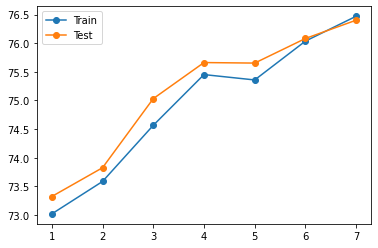

The point of NO overfitting is 7
Score:
76.40182648401826


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

trainScores, testScores = list(), list()
treeDepths = [i for i in range(1, 8)]

for i in treeDepths:
    model = RandomForestClassifier(max_depth=i)
    model.fit(X_train, y_train)
    
    trainPrediction = model.predict(X_train)
    trainAccuracy = accuracy_score(y_train, trainPrediction) * 100
    trainScores.append(trainAccuracy)
    
    testPrediction = model.predict(X_test)
    testAccuracy = accuracy_score(y_test, testPrediction) * 100
    testScores.append(testAccuracy)
    
    print('>%d, train: %.3f, test: %.3f' % (i, trainAccuracy, testAccuracy))

pyplot.plot(treeDepths, trainScores, '-o', label='Train')
pyplot.plot(treeDepths, testScores, '-o', label='Test')
pyplot.legend()
pyplot.show()

print("The point of NO overfitting is 7")
print("Score:")
print(model.score(X_test, y_test)*100)

## Decision Tree Classifier ~75%

>1, train: 67.858, test: 68.904
>2, train: 71.077, test: 72.000
>3, train: 71.986, test: 72.219
>4, train: 74.180, test: 74.155
>5, train: 74.493, test: 74.658
>6, train: 75.080, test: 75.187
>7, train: 75.448, test: 75.196
>8, train: 76.338, test: 75.799


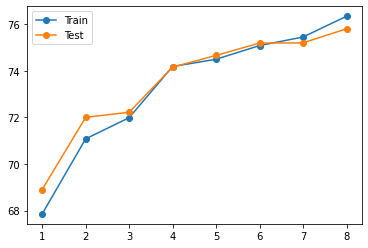

The point of NO overfitting is 8
Score:
75.79908675799086


In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

trainScores, testScores = list(), list()
treeDepths = [i for i in range(1, 9)]

for i in treeDepths:
    model = DecisionTreeClassifier(max_depth=i)
    model.fit(X_train, y_train)
    
    trainPrediction = model.predict(X_train)
    trainAccuracy = accuracy_score(y_train, trainPrediction) * 100
    trainScores.append(trainAccuracy)
    
    testPrediction = model.predict(X_test)
    testAccuracy = accuracy_score(y_test, testPrediction) * 100
    testScores.append(testAccuracy)
    
    print('>%d, train: %.3f, test: %.3f' % (i, trainAccuracy, testAccuracy))

pyplot.plot(treeDepths, trainScores, '-o', label='Train')
pyplot.plot(treeDepths, testScores, '-o', label='Test')
pyplot.legend()
pyplot.show()

print("The point of NO overfitting is 8")
print("Score:")
print(model.score(X_test, y_test) * 100)

## Support Vector Machines ~76%

In [24]:
from sklearn import svm

svc = svm.SVC(gamma="scale", random_state=10)
svc.fit(X_train, y_train)

print("Score:")
print(svc.score(X_test, y_test) * 100)

Score:
76.1187214611872


## NN aka Multi-Layer Perceptrons ~76%

>1, train: 73.673, test: 73.927
>2, train: 75.096, test: 75.105
>3, train: 75.205, test: 75.297
>4, train: 75.390, test: 75.452
>5, train: 75.603, test: 75.580
>6, train: 75.838, test: 75.836
>7, train: 76.062, test: 76.000
>8, train: 76.251, test: 76.183
>9, train: 76.096, test: 76.228
>10, train: 76.489, test: 76.402
>11, train: 76.530, test: 76.292
>12, train: 76.575, test: 76.447
>13, train: 76.575, test: 76.484
>14, train: 76.336, test: 76.311
>15, train: 76.537, test: 76.447
>16, train: 76.676, test: 76.429
>17, train: 76.642, test: 76.438
>18, train: 76.646, test: 76.484
>19, train: 76.690, test: 76.420
>20, train: 76.728, test: 76.393
>21, train: 76.356, test: 76.210
>22, train: 76.669, test: 76.338
>23, train: 76.432, test: 76.283
>24, train: 76.722, test: 76.365
>25, train: 76.731, test: 76.347
>26, train: 76.660, test: 76.329
>27, train: 76.726, test: 76.228
>28, train: 76.856, test: 76.347
>29, train: 76.829, test: 76.256
>30, train: 76.802, test: 76.329
>31, train: 76.865,

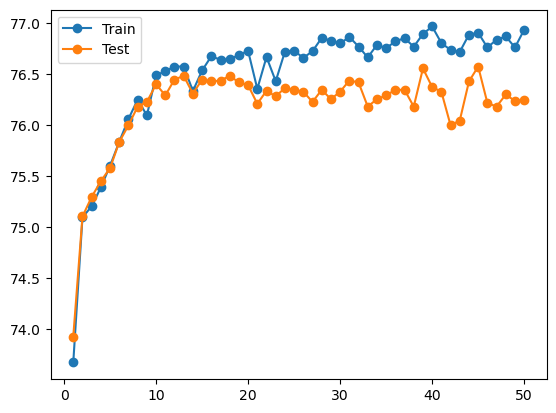

The point of NO overfitting is XX
Score:
76.24657534246575


In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

trainScores, testScores = list(), list()
iterations = [i for i in range(1, 51)] #1500? takes a long time

for i in iterations:
    model = MLPClassifier(max_iter=i, random_state=10)
    model.fit(X_train, y_train)
    
    trainPrediction = model.predict(X_train)
    trainAccuracy = accuracy_score(y_train, trainPrediction) * 100
    trainScores.append(trainAccuracy)
    
    testPrediction = model.predict(X_test)
    testAccuracy = accuracy_score(y_test, testPrediction) * 100
    testScores.append(testAccuracy)
    
    print('>%d, train: %.3f, test: %.3f' % (i, trainAccuracy, testAccuracy))

pyplot.plot(iterations, trainScores, '-o', label='Train')
pyplot.plot(iterations, testScores, '-o', label='Test')
pyplot.legend()
pyplot.show()

print("The point of NO overfitting is XX")
print("Score:")
print(model.score(X_test, y_test) * 100)

In [26]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=1000, random_state=10)
mlp.fit(X_train, y_train)

print("Accuracy on training set:{:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set:{:.2f}".format(mlp.score(X_test, y_test)))


Accuracy on training set:0.77
Accuracy on test set:0.76


## ROC - Receiver Operating Characteristic

To evaluate classifier output quality.
ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one.

In [27]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=1000, random_state=10)
mlp.fit(X_train, y_train)

print("Accuracy on training set:{:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set:{:.2f}".format(mlp.score(X_test, y_test)))

Accuracy on training set:0.77
Accuracy on test set:0.76


In [28]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
y_pred_proba = model.predict_proba(X_test)
y_pred_proba[5:10]
y_pred_proba = y_pred_proba[:,1]


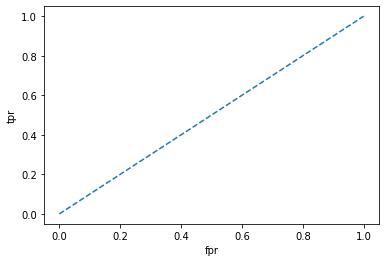

In [29]:
import matplotlib.pyplot as plt
plt.plot([0,1], [0,1], linestyle ='--')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

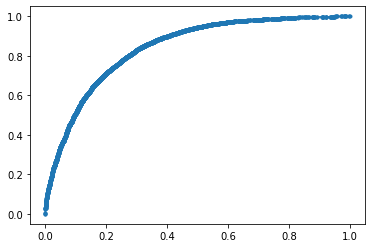

In [30]:
fpr, tpr, tresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, marker ='.')

Best Case: AUC = 1.0 (everything correctly classified). AUC = 0.5 - 50% accurate (random guess)

In [31]:
auc = roc_auc_score(y_test, y_pred_proba)
print('AUC: %.3f' % auc)

AUC: 0.842


# EXPORT MODEL

Exports a newly created file in the same directory as this file

In [11]:
import pickle

writeBinaryMode = 'wb'
fileName = 'heartPredictionModel.pkl'
pickle.dump(model, open(fileName, writeBinaryMode))